In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy
import pandas

In [3]:
hist_kw = dict(bins=60, normed=True, alpha=0.5)

# KS investigation (with negative weights)

Download 

* `check_agreement.csv`, 

to the folder `datasets/` from https://www.kaggle.com/c/flavours-of-physics/data

It is a control channel, where 1-label corresponds to MC, 0-label - real data, `weight` - sPlot weights

In [4]:
data_agreement = pandas.read_csv('datasets/check_agreement.csv')
features_for_ks = ['LifeTime', 'FlightDistance', 'IPSig', 'SPDhits']

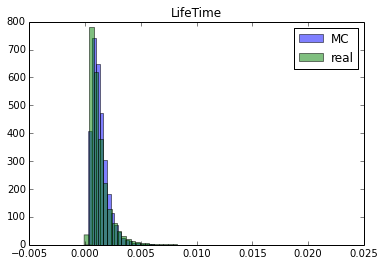

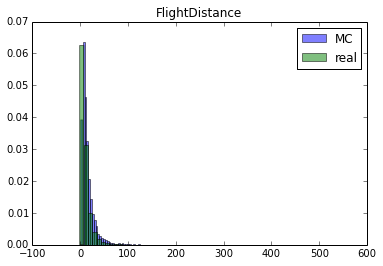

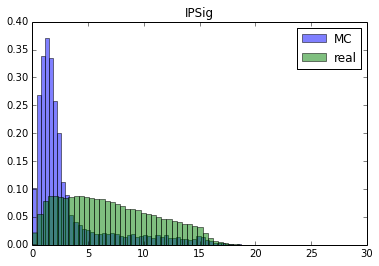

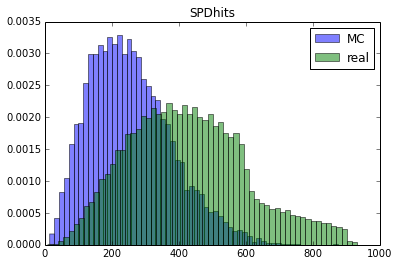

In [5]:
for feature in features_for_ks:
    hist(data_agreement[data_agreement.signal == 1][feature].values, label='MC', **hist_kw)
    hist(data_agreement[data_agreement.signal == 0][feature].values, label='real', **hist_kw)
    legend()
    title(feature)
    show()

### Check how sPlot weights change real data pdfs

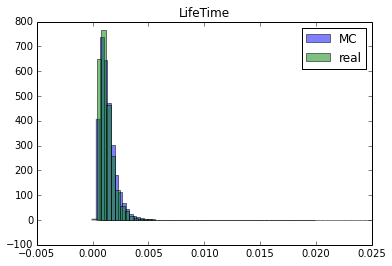

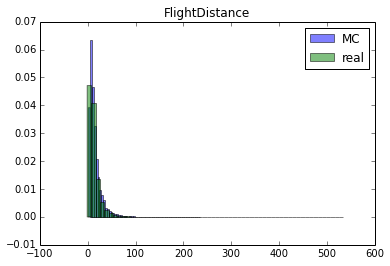

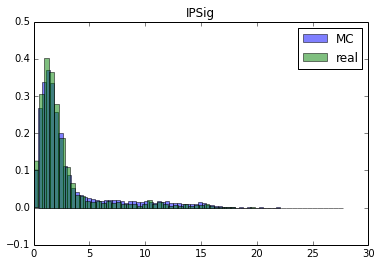

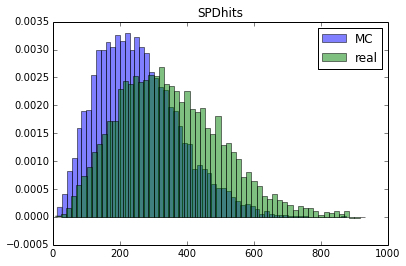

In [6]:
for feature in features_for_ks:
    hist(data_agreement[data_agreement.signal == 1][feature].values,
         weights=data_agreement[data_agreement.signal == 1]['weight'].values, label='MC', **hist_kw)
    hist(data_agreement[data_agreement.signal == 0][feature].values,
         weights=data_agreement[data_agreement.signal == 0]['weight'].values, label='real', **hist_kw)
    title(feature)
    legend()
    show()

## Write KS for weights pdfs
standard function doesn't support weights :(

In [7]:
from sklearn.metrics import roc_curve
def compute_ks(pdf1, pdf2, weights1=None, weights2=None):
    # Write KS metric between two weighted pdfs (see slides)
    if weights1 is None:
        weights1 = numpy.ones(len(pdf1))
    if weights2 is None:
        weights2 = numpy.ones(len(pdf2))
    labels = [0] * len(pdf1) + [1] * len(pdf2)
    values = numpy.concatenate([numpy.array(pdf1), numpy.array(pdf2)]) 
    weights = numpy.concatenate([numpy.array(weights1), numpy.array(weights2)]) 
    fpr, tpr, _ = roc_curve(labels, values, sample_weight=weights)
    return numpy.max(abs(fpr - tpr))

## KS metric pdf generation

There are several things to know before doing it:

* we cannot produce two samples from the same distribution with the weights, thus if we generate two samples from uniform and then compute weighted ks metric, obtained value will be greater than it is. That is why during testing hypothesis the probability of error type I will be greater than it is really (Our KS pdf will give the upper estimation of probability to reject H0, when it is true)

* the second sample contains signal and background, which are sampled from different distributions.  
In the second sample we need to generate not only signal (from the same distribution), but also bck from any distribution. But if we remember about sPlot weights property (they compensate bck) then we can conclude that generated bck could be compensated in sample using weights. Of course, some fluctuations can arise (maybe we should somehow estimate them)!

* in the first approximation we can generate two samples as before

###TODO

* Check that for unweighted samples KS will be lower than for weighted.

In [8]:
# finish the function
def generate_ks_pdf(n1, n2, w1=None, w2=None, points=3000):
    ks = []
    # for each point 
    for step in range(points):
        # generate pdf1 and pdf2 from the same distributions
        pdf1 = numpy.random.random(size=n1)
        pdf2 = numpy.random.random(size=n2)
        # compute ks for generated pdfs
        ks.append(compute_ks(pdf1, pdf2, weights1=w1, weights2=w2))
    return numpy.array(ks)

In [9]:
n1 = numpy.sum(data_agreement.signal == 0)
n2 = numpy.sum(data_agreement.signal == 1)
w1 = data_agreement[data_agreement.signal == 0]['weight'].values
w2 = data_agreement[data_agreement.signal == 1]['weight'].values
ks_pdf = generate_ks_pdf(n1, n2)
ks_pdf_weight = generate_ks_pdf(n1, n2, w1=w1, w2=w2)

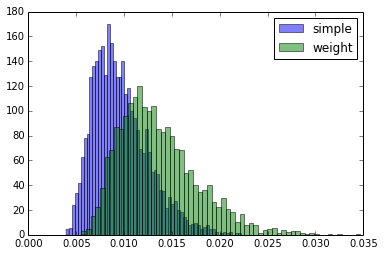

In [10]:
hist(ks_pdf, label='simple', **hist_kw)
hist(ks_pdf_weight, label='weight', **hist_kw)
legend()
pass

###TODO:
What features have least disagreement among `features_for_ks`?

In [11]:
for feature in features_for_ks:
    pdf1 = data_agreement[data_agreement.signal == 0][feature].values
    pdf2 = data_agreement[data_agreement.signal == 1][feature].values
    print feature, 'ks', compute_ks(pdf1, pdf2, weights1=w1, weights2=w2)

LifeTime ks 0.0822640147111
FlightDistance ks 0.107391315987
IPSig ks 0.0694932126176
SPDhits ks 0.25816733476


# Agreement restriction on the classifiers

How more disagreement features can influence the predictions agreement and classifier's quality?

Do for this:

* train any ensemble model on all features
* remove `SPDhits` from training

In the competition your ks metric should be less than **0.09**

In [12]:
data = pandas.read_csv('datasets/training.csv')
train_features = list(set(data_agreement.columns) - {'id', 'signal', 'weight'})
train_features_wo_spd = list(set(data_agreement.columns) - {'id', 'signal', 'weight', 'SPDhits'})

In [13]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [14]:
# Divide train on train, test
train_index, test_index = train_test_split(range(len(data)))
train = data.iloc[train_index, :]
test = data.iloc[test_index, :]

In [15]:
# define function to test model on ks and calculate quality
def test_model(model, features):
    probs = model.predict_proba(data_agreement[features])[:, 1]
    pdf1 = probs[data_agreement.signal.values == 0]
    pdf2 = probs[data_agreement.signal.values == 1]
    model_agr = compute_ks(pdf1, pdf2, weights1=w1, weights2=w2)
    print 'Agreement', model_agr, model_agr < 0.09
    print 'AUC', roc_auc_score(test.signal.values, model.predict_proba(test[features])[:, 1])

In [16]:
# train gradient boosting
gb = GradientBoostingClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, min_samples_leaf=50, subsample=0.7, 
                                max_features=20)
gb.fit(train[train_features], train['signal'].values)
test_model(gb, train_features)

Agreement 0.246497614514 False
AUC 0.951474683899


In [17]:
# train gradient boosting without SPDhits
gb = GradientBoostingClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, min_samples_leaf=50, subsample=0.7, 
                                max_features=20)
gb.fit(train[train_features_wo_spd], train['signal'].values)
test_model(gb, train_features_wo_spd)

Agreement 0.107066993109 False
AUC 0.940646827034


### Does subsample parameter influence the agreement and the quality?

In [18]:
for subsample in [0.1, 0.3, 0.5, 0.7, 0.9]:
    gb = GradientBoostingClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, min_samples_leaf=50, 
                                    subsample=subsample, 
                                    max_features=20)
    gb.fit(train[train_features], train['signal'].values)
    test_model(gb, train_features)

Agreement 0.220064244529 False
AUC 0.949761015934
Agreement 0.236327647584 False
AUC 0.951107863133
Agreement 0.246617530873 False
AUC 0.951885235513
Agreement 0.247052545375 False
AUC 0.951780200578
Agreement 0.244391673943 False
AUC 0.951316097776


In [19]:
for subsample in [0.1, 0.3, 0.5, 0.7, 0.9]:
    gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, min_samples_leaf=50, subsample=subsample, 
                                    max_features=20, max_depth=6)
    gb.fit(train[train_features_wo_spd], train['signal'].values)
    test_model(gb, train_features_wo_spd)

Agreement 0.0961025661419 False
AUC 0.937792411657
Agreement 0.104156254635 False
AUC 0.94008113503
Agreement 0.102205145585 False
AUC 0.940905421816
Agreement 0.1110309315 False
AUC 0.940909302011
Agreement 0.105840006739 False
AUC 0.94073315014


### Does learning rate influence?

In [20]:
for lrate in [0.05, 0.1, 0.2, 0.5]:
    gb = GradientBoostingClassifier(n_estimators=300, learning_rate=lrate, min_samples_leaf=50, subsample=0.5, 
                                    max_features=20, max_depth=6)
    gb.fit(train[train_features_wo_spd], train['signal'].values)
    test_model(gb, train_features_wo_spd)

Agreement 0.104523330864 False
AUC 0.941467990188
Agreement 0.11635678302 False
AUC 0.9408548819
Agreement 0.11888452615 False
AUC 0.934752885502
Agreement 0.0820799811734 True
AUC 0.914126719383


# Example of overfitting-complexity

In [21]:
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.7, min_samples_leaf=50, subsample=0.5, 
                                max_features=20, max_depth=6)
gb.fit(train[train_features_wo_spd], train['signal'].values)

steps = []
for probs in gb.staged_predict_proba(test[train_features_wo_spd]):
    steps.append(roc_auc_score(test.signal.values, probs[:, 1]))
steps_train = []
for probs in gb.staged_predict_proba(train[train_features_wo_spd]):
    steps_train.append(roc_auc_score(train.signal.values, probs[:, 1]))

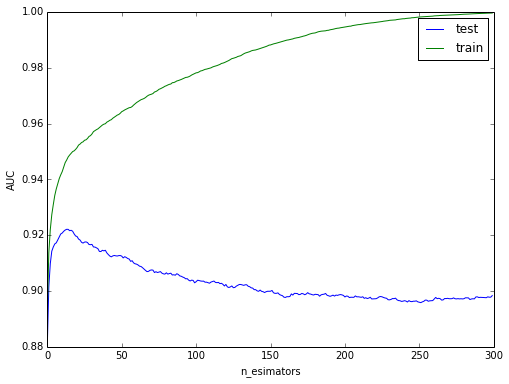

In [22]:
figsize(8, 6)
plot(range(len(steps)), steps, label='test')
plot(range(len(steps_train)), steps_train, label='train')
legend(loc='best')
ylabel('AUC')
xlabel('n_esimators')

The quality on the train is increasing while the quality on the test is decreasing. This is really overfitting. We need take those number of iterations for which quality on test sample is qrowing.

### Summarize:

* The simple solution to improve an agreement is to remove too disagreement features from the training. 
* There are exist smart solutions which will be study on the next seminars.

# Training on sPlot data
There are several ways how to train classifier on sPlot data:

* Choose some threshold > 0 on weights and suppose that events with greater weights are signal and threshold < 0 to define background (this is in consistence with weights meaning).
* As weights are linear combination of $p_s(y)$ and $p_b(y)$, one can put all events with $p_s(y)$ weight as signal and all events with $1 - p_s(y)$ as background.
* apply bagging and select signal event from all events with $p_s(y)$ probability and backgroud events with $p_b(y)$ one.
* apply bagging and and put 1-label with $p_s(y)$ probability and 0-labelwith $p_b(y)$.
* maybe other ways

**TODO**: 

* Try all listed ways compared them on the test dataset (`test_splot`). Test contains MC for $\tau\to 3\mu$ and its sideband. On this data quality will be lower than it is actually is, because $\tau\to 3\mu$ differs from $D_s\to\phi\pi$
* Can you suggest another way how to train classifier on sPlot data?

**Note: the $p_s$ column is defined in the file `probabilities.csv` in folder `datasets`**

In [23]:
read_columns = list(set(data_agreement.columns) - {'weight'})

In [24]:
splot_data = data_agreement[data_agreement.signal == 0]
# probabilities to be signal events
splot_probs = pandas.read_csv('datasets/probabilities.csv')['probs'].values
test_splot = data

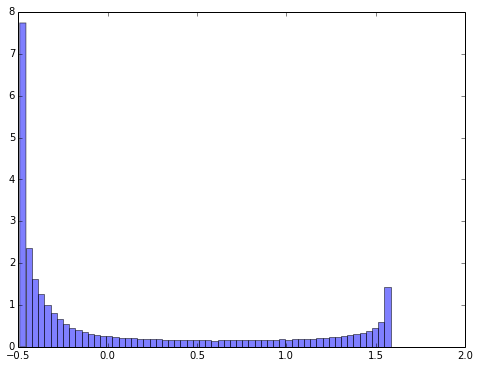

In [25]:
# plot weights
hist(splot_data.weight.values, **hist_kw)
pass

### Choose weight thresholds (say >1. for signal and  <-0.4 for bck)
Remember that selected parts of data are not actually signal and bck.

In [26]:
all_data = splot_data.query('(weight > 1.) | (weight < -0.4)')
labels = (all_data.weight.values > 0) * 1
# train gradient boosting
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, min_samples_leaf=50, subsample=0.5, 
                                max_features=20, max_depth=6)
gb.fit(all_data[train_features], labels, sample_weight=abs(all_data.weight.values))
roc_auc_score(test_splot.signal.values, gb.predict_proba(test_splot[train_features])[:, 1])

0.88927308166226893

### Add events two times in training

First time as signal with weight = probability_signal.

Second time as background with weight = 1 - probability_signal. 

This method is equivalent to the following function optimization in logloss case for boosting:

$\mathbb{L} = \sum_{y} p_s(y) * \log{\hat{p}(y)} + (1 - p_s(y)) * \log{(1 - \hat{p}(y))} =  \sum_{y} label(y) * w(y) \log{\hat{p}(y)} +  (1 - label(y)) *  w(y)  \log{(1 - \hat{p}(y))}$, 

where $\hat{p}$ is classifier's prediction and the right side is logloss in boosting

In [27]:
all_data = pandas.concat([splot_data, splot_data])
labels = [0] * len(splot_data) + [1] * len(splot_data)
weights = numpy.concatenate([1 - splot_probs, splot_probs])
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, min_samples_leaf=50, subsample=0.5, 
                                max_features=20, max_depth=6)
gb.fit(all_data[train_features], labels, sample_weight=weights)
roc_auc_score(test_splot.signal.values, gb.predict_proba(test_splot[train_features])[:, 1])

0.88870267500179134

### Lirical thoughts: How this result can help to search for $\tau\to 3\mu$? 

In [28]:
train['new_feature'] = gb.predict_proba(train[train_features])[:, 1]
test['new_feature'] = gb.predict_proba(test[train_features])[:, 1]
data_agreement['new_feature'] = gb.predict_proba(data_agreement[train_features])[:, 1]

/Users/antares/.virtualenvs/test/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/antares/.virtualenvs/test/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [29]:
gb_new = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, min_samples_leaf=50, subsample=0.7, 
                                    max_features=20, max_depth=6)
gb_new.fit(train[train_features_wo_spd + ['new_feature']], train['signal'].values)
test_model(gb_new, train_features_wo_spd + ['new_feature'])

Agreement 0.102836902934 False
AUC 0.941348715386


### Bagging with events sampler

In [30]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import clone
# define sampler corresponding to probabilities (generate signal events using ifs pdf, the same for bck)
class SampleSampler(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, n_estimators=10, bootstrap=False, subsample=0.5):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.subsample = subsample
        
    def fit(self, X, y, sample_weight=None):
        # finish method: generate samples
        if sample_weight is None:
            sample_weight = numpy.ones(len(y))
        y = numpy.array(y)
        X = numpy.array(X)
        
        sig_size = int(self.subsample * numpy.sum(y == 1))
        p_sig = sample_weight[y == 1]
        p_sig /= p_sig.sum()
        
        bck_size = int(self.subsample * numpy.sum(y == 0))
        p_bck = 1 - sample_weight[y == 0]
        p_bck /= p_bck.sum()
        self.estimators = []
        for _ in range(self.n_estimators):
            base = clone(self.base_estimator)
            used_samples = numpy.random.choice(numpy.where(y == 1)[0], size=sig_size,
                                                    replace=self.bootstrap,
                                                    p=p_sig)
            used_samples = numpy.concatenate([used_samples,
                                              numpy.random.choice(numpy.where(y == 0)[0], size=bck_size,
                                                                replace=self.bootstrap,
                                                                p=p_bck)])
            
            base.fit(X[used_samples, :], y[used_samples], sample_weight=sample_weight[used_samples])

            self.estimators.append(base)
        return self
    
    def predict_proba(self, X):
        result = numpy.zeros([len(X), 2])
        for clf in self.estimators:
            result += clf.predict_proba(X)
        return result / len(self.estimators)
    
    def predict(self, X):
        return numpy.argmax(self.predict_proba(X), axis=1)
            

In [31]:
all_data = pandas.concat([splot_data, splot_data])
labels = [0] * len(splot_data) + [1] * len(splot_data)
weights = numpy.concatenate([splot_probs, splot_probs])

gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.7, min_samples_leaf=50, subsample=0.5, 
                                max_features=8, max_depth=6)
sampler = SampleSampler(gb)
sampler.fit(all_data[train_features], labels, sample_weight=weights)
roc_auc_score(test_splot.signal.values, sampler.predict_proba(test_splot[train_features])[:, 1])

0.58870345832542026

### Another sampler

In [32]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import clone
# define sampler corresponding to probabilities (generate labels for event using probabilities)
class BaggingSampler(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, n_estimators=10):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        
    def fit(self, X, y, sample_weight=None):
        # finish method
        if sample_weight is None:
            sample_weight = numpy.ones(len(y))
        y = numpy.array(y)
        X = numpy.array(X)
        new_y = numpy.random.random(size=len(y)) < sample_weight
        self.estimators = []
        for _ in range(self.n_estimators):
            base = clone(self.base_estimator)
            base.fit(X, new_y)
            self.estimators.append(base)
        return self
    
    def predict_proba(self, X):
        result = numpy.zeros([len(X), 2])
        for clf in self.estimators:
            result += clf.predict_proba(X)
        return result / len(self.estimators)
    
    def predict(self, X):
        return numpy.argmax(self.predict_proba(X), axis=1)
            

In [33]:
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.7, min_samples_leaf=50, subsample=0.5, 
                                max_features=8, max_depth=6)
sampler = BaggingSampler(gb)
sampler.fit(splot_data[train_features], numpy.ones(len(splot_data)), sample_weight=splot_probs)
roc_auc_score(test_splot.signal.values, sampler.predict_proba(test_splot[train_features])[:, 1])

0.77131139583832953

## Summarize:

* Different ways are possible to train classifier using probablity information from data.
* Sometimes you need to train on sPlot data (take only singal) vs MC background. In this case you have two possibilities how to choose signal events
    * make cut on sPlot weights (note, that only classifiers from TMVA library can use negative weights for events)
    * choose events using sampling with signal probability